In [9]:
import gymnasium as gym
import torch
import torch.nn.functional as F
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
import rl_utils

In [41]:
class PolicyNet(torch.nn.Module):
    def __init__(self, state_dim, hidden_dim, action_dim):
        super().__init__()
        self.fc1 = torch.nn.Linear(state_dim, hidden_dim)
        self.fc2 = torch.nn.Linear(hidden_dim, action_dim)

    def forward(self, x):
        x = F.relu(self.fc1(x))
        return F.softmax(self.fc2(x))

In [49]:
class REINFORCE:
    def __init__(self, state_dim, hidden_dim, action_dim, learning_rate, gamma, device):
        self.policy_net = PolicyNet(state_dim, hidden_dim, action_dim).to(device)
        self.optimizer = torch.optim.Adam(self.policy_net.parameters(), lr=learning_rate)
        self.gamma = gamma
        self.device = device
    
    def take_action(self, state):
        state = torch.tensor([state], dtype=torch.float).to(self.device)
        probs = self.policy_net(state)
        action_dist = torch.distributions.Categorical(probs)
        action = action_dist.sample()
        return action.item()
    
    def update(self, transition_dict):
        states = torch.tensor(transition_dict['states'], dtype=torch.float).to(self.device)
        actions = torch.tensor(transition_dict['actions']).view(-1, 1).to(self.device)
        rewards = torch.tensor(transition_dict['rewards'], dtype=torch.float).to(self.device)

        G = 0
        self.optimizer.zero_grad()

        for i in reversed(range(len(rewards))):
            reward = rewards[i]
            state = torch.tensor(states[i], dtype=torch.float).to(self.device)
            action = torch.tensor([actions[i]]).view(-1, 1).to(self.device)
            log_prob = torch.log(self.policy_net(state)[action])
            G = self.gamma * G + reward
            loss = -log_prob * G
            loss.backward()
        self.optimizer.step()

In [50]:
learning_rate = 1e-3
num_episodes = 1000
hidden_dim = 128
gamma = 0.98
device = torch.device("cuda") if torch.cuda.is_available() else torch.device(
    "cpu")

env_name = "CartPole-v1"
env = gym.make(env_name)
env.action_space.seed(0)
torch.manual_seed(0)
state_dim = env.observation_space.shape[0]
action_dim = env.action_space.n
agent = REINFORCE(state_dim, hidden_dim, action_dim, learning_rate, gamma,
                  device)

return_list = []
for i in range(10):
    with tqdm(total=int(num_episodes / 10), desc='Iteration %d' % i) as pbar:
        for i_episode in range(int(num_episodes / 10)):
            episode_return = 0
            transition_dict = {
                'states': [],
                'actions': [],
                'next_states': [],
                'rewards': [],
                'dones': []
            }
            state = env.reset()[0]
            done = False
            while not done:
                action = agent.take_action(state)
                next_state, reward, done, _ = env.step(action)[0:4]
                transition_dict['states'].append(state)
                transition_dict['actions'].append(action)
                transition_dict['next_states'].append(next_state)
                transition_dict['rewards'].append(reward)
                transition_dict['dones'].append(done)
                state = next_state
                episode_return += reward
            return_list.append(episode_return)
            agent.update(transition_dict)
            if (i_episode + 1) % 10 == 0:
                pbar.set_postfix({
                    'episode':
                    '%d' % (num_episodes / 10 * i + i_episode + 1),
                    'return':
                    '%.3f' % np.mean(return_list[-10:])
                })
            pbar.update(1)

Iteration 0:   0%|          | 0/100 [00:00<?, ?it/s]/tmp/ipykernel_1208/4191743058.py:9: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return F.softmax(self.fc2(x))
/tmp/ipykernel_1208/486179478.py:25: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  state = torch.tensor(states[i], dtype=torch.float).to(self.device)
Iteration 9: 100%|██████████| 100/100 [00:27<00:00,  3.68it/s, episode=1000, return=504.800]


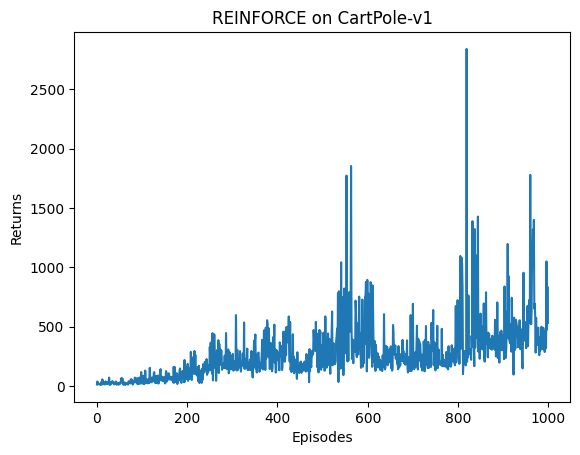

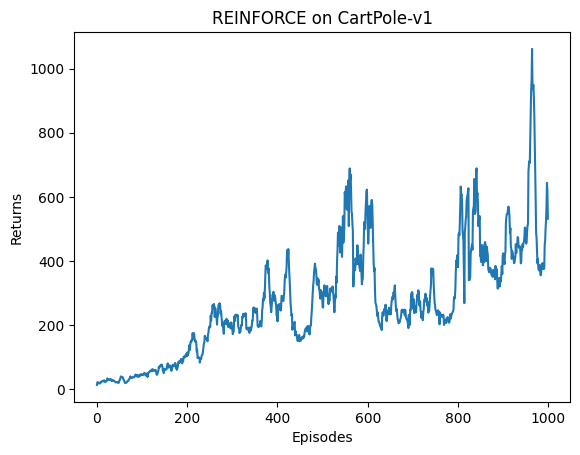

In [51]:
episodes_list = list(range(len(return_list)))
plt.plot(episodes_list, return_list)
plt.xlabel('Episodes')
plt.ylabel('Returns')
plt.title('REINFORCE on {}'.format(env_name))
plt.show()

mv_return = rl_utils.moving_average(return_list, 9)
plt.plot(episodes_list, mv_return)
plt.xlabel('Episodes')
plt.ylabel('Returns')
plt.title('REINFORCE on {}'.format(env_name))
plt.show()